In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
L1 = 0.5
L2 = 0.3

minRadius = L1 - L2
maxRadius = L1 + L2

# wasn't quite sure how to incorporate the limits into the controller
# but I visually confirm that the limits are respected
theta_limits = [-90,90]

home_theta = [0.0,0.0]
pick_theta = [30,-20]
place_theta = [45,-30]

#testing thetas
pick_theta = [-80,70]
place_theta = [45,-30]

current_theta1 = home_theta[0]
w1 = 0.0
current_theta2 = home_theta[1]
w2 = 0.0
 
clock = 60
period = 1/clock

# time per movement in seconds
t_move = 5

# frames to evaluate per movement
frames = int(t_move * clock)

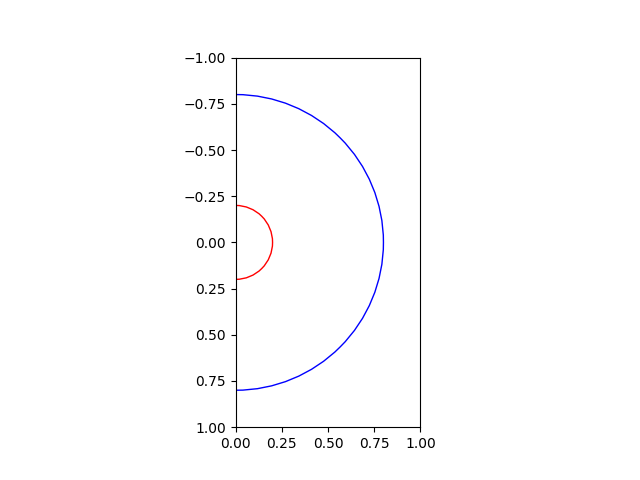

In [3]:
import matplotlib.animation as animation

fig , ax = plt.subplots()
ax.set_xlim(0.0, 1.0)
ax.set_ylim(1.0, -1.0)
ax.set_aspect('equal')

maxCircle = plt.Circle((0, 0), maxRadius, color='blue', fill=False)
minCircle = plt.Circle((0, 0), minRadius, color='red', fill=False)

ax.add_patch(maxCircle)
ax.add_patch(minCircle)

In [4]:
# kp and kv are global variables defined below
# inertia is arbitrary and set to 1 in the controller
# so it isn't super realistic for a 2R manipulator


# increase kp for a stronger "spring"
kp = 10
# increase kv for a stronger "damper"
kv = 5

def controller(current_w, current_theta, desired_theta):
    error = desired_theta - current_theta
    torque = kp*(error) - kv*current_w
    next_w = current_w + torque * period
    return next_w, torque

In [5]:
# pick movement
joint1 = [home_theta[0]]
joint2 = [home_theta[1]]
torques1 = [0]
torques2 = [0]

# calculating pick thetas
for n in range(frames):
    current_theta1 += period*w1
    joint1.append(current_theta1)
    w1, torque = controller(w1, current_theta1, pick_theta[0])
    torques1.append(torque)
    current_theta2 += period*w2
    joint2.append(current_theta2)
    w2, torque = controller(w2, current_theta2, pick_theta[1])
    torques2.append(torque)

# calulating place thetas
for n in range(frames):
    current_theta1 += period*w1
    joint1.append(current_theta1)
    w1, torque = controller(w1, current_theta1, place_theta[0])
    torques1.append(torque)
    current_theta2 += period*w2
    joint2.append(current_theta2)
    w2, torque = controller(w2, current_theta2, place_theta[1])
    torques2.append(torque)


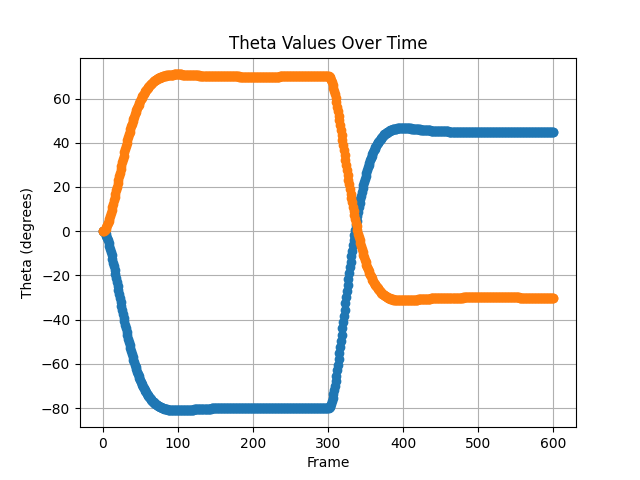

In [6]:
y1 = np.asarray(joint1)
y2 = np.asarray(joint2)
x = np.arange(len(y1))

plt.figure()
plt.plot(x, y1, marker='o')  # line with points
plt.plot(x, y2, marker='o')
plt.xlabel("Frame")
plt.ylabel("Theta (degrees)")
plt.title("Theta Values Over Time")
plt.grid(True)
plt.show()

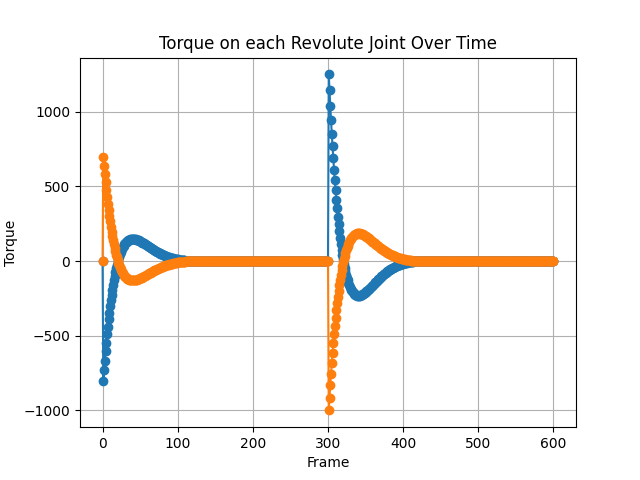

In [7]:
y1 = np.asarray(torques1)
y2 = np.asarray(torques2)
x = np.arange(len(torques1))

plt.figure()
plt.plot(x, y1, marker='o')  # line with points
plt.plot(x, y2, marker='o')
plt.xlabel("Frame")
plt.ylabel("Torque")
plt.title("Torque on each Revolute Joint Over Time")
plt.grid(True)
plt.show()

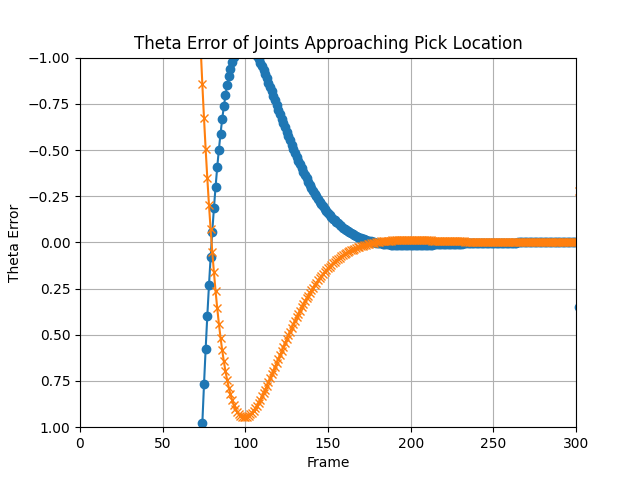

In [11]:
# plot EE performance at pick and place points
error1 = np.asarray(joint1) - pick_theta[0]
error2 = np.asarray(joint2) - pick_theta[1]
pick_frames = range(frames)
place_frames = range(frames, 2*frames)

plt.figure()
plt.plot(x, error1, marker='o')  # line with points
plt.plot(x, error2, marker='x')
plt.ylim(1.0, -1.0)
plt.xlim(0,frames)
plt.xlabel("Frame")
plt.ylabel("Theta Error")
plt.title("Theta Error of Joints Approaching Pick Location")
plt.grid(True)
plt.show()


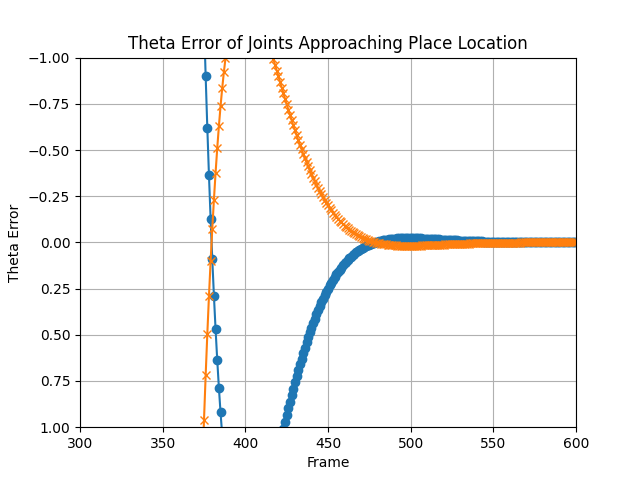

In [9]:
# plot EE performance at pick and place points
error1 = np.asarray(joint1) - place_theta[0]
error2 = np.asarray(joint2) - place_theta[1]

plt.figure()
plt.plot(x, error1, marker='o')  # line with points
plt.plot(x, error2, marker='x')
plt.ylim(1.0, -1.0)
plt.xlim(frames,2*frames)
plt.xlabel("Frame")
plt.ylabel("Theta Error")
plt.title("Theta Error of Joints Approaching Place Location")
plt.grid(True)
plt.show()

In [10]:
middle_x = []
middle_y = []
ee_x = []
ee_y = []

for theta in joint1:
  middle_x.append(math.cos(theta*math.pi/180)*L1)
  middle_y.append(math.sin(theta*math.pi/180)*L1)

for i, theta in enumerate(joint2):
  ee_x.append(middle_x[i] + math.cos((theta+joint1[i])*math.pi/180)*L2)
  ee_y.append(middle_y[i] + math.sin((theta+joint1[i])*math.pi/180)*L2)


(l1_line,) = ax.plot([], [], lw=3)
(l2_line,) = ax.plot([], [], lw=3)

pick_x = math.cos(pick_theta[0]*math.pi/180)*L1 + math.cos((pick_theta[0]+pick_theta[1])*math.pi/180)*L2
pick_y = math.sin(pick_theta[0]*math.pi/180)*L1 + math.sin((pick_theta[0]+pick_theta[1])*math.pi/180)*L2
place_x = math.cos(place_theta[0]*math.pi/180)*L1 + math.cos((place_theta[0]+place_theta[1])*math.pi/180)*L2
place_y = math.sin(place_theta[0]*math.pi/180)*L1 + math.sin((place_theta[0]+place_theta[1])*math.pi/180)*L2

ax.plot(pick_x, pick_y,  'ro', label='Pick')   # red circle
ax.plot(place_x, place_y, 'go', label='Place') # green circle

ax.text(pick_x,  pick_y,  ' Pick',  fontsize=10, va='bottom', ha='left')
ax.text(place_x, place_y, ' Place', fontsize=10, va='bottom', ha='left')

ax.legend()

def update(frame):
    # for each frame, update the data stored on each artist.
    x_base = 0.0
    y_base = 0.0

    x_middle = middle_x[frame]
    y_middle = middle_y[frame]

    x_ee = ee_x[frame]
    y_ee = ee_y[frame]

    # update the scatter plot:
    l1_line.set_data([x_base, x_middle], [y_base, y_middle])
    l2_line.set_data([x_middle, x_ee], [y_middle, y_ee])

    return l1_line, l2_line

# interval in milliseconds, defined by the clock so the animation is in "real-time"
# ani = animation.FuncAnimation(fig=fig, func=update, frames=len(ee_y), interval=(period*1000))
# plt.show()
# ani.save("pa3_2r.mp4", dpi=300)